Prob need to quantile normalize the samples for bulk. Lets see what that looks like

In [90]:
import pandas as pd
import anndata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import quantile_transform


In [6]:
adata = anndata.read_h5ad('/pipeline42/datasets/Gtex/GTEx_K20')

In [17]:
adatadf = adata.to_df()

In [32]:
adatadf_sample = adatadf.T.sample(10, axis = 1)

In [33]:
adatadf_sample.head()

SAMPID,GTEX-1R9JW-2426-SM-DTXFI,GTEX-18A6Q-1726-SM-7LT9A,GTEX-1JN6P-2626-SM-D4P3C,GTEX-ZAB4-3126-SM-57WCJ,GTEX-1LG7Z-0326-SM-DHXK3,GTEX-ZF29-1926-SM-5S2P1,GTEX-1GMR8-3126-SM-9WPOR,GTEX-QXCU-1926-SM-48FE4,GTEX-15DYW-0006-SM-7RHFR,GTEX-13FTX-1526-SM-5K7VJ
Description,,,,,,,,,,
DDX11L1,0.000,0.0000,0.02198,0.000,0.00000,0.000,0.05703,0.00,0.09728,0.03738
WASH7P,2.666,0.8378,6.18100,9.678,0.47300,5.867,7.46300,1.62,3.74900,4.69600
MIR6859-1,0.000,0.0000,0.00000,0.000,0.00000,0.000,0.72510,0.00,0.00000,0.00000
MIR1302-2HG,0.000,0.0000,0.00000,0.000,0.02073,0.000,0.05694,0.00,0.00000,0.00000
FAM138A,0.000,0.0000,0.03117,0.000,0.00000,0.000,0.00000,0.00,0.00000,0.02651


In [36]:
adatadf_melt = adatadf_sample.melt()

In [44]:
adatadf_melt

,SAMPID,value
0,GTEX-1R9JW-2426-SM-DTXFI,0.000000
1,GTEX-1R9JW-2426-SM-DTXFI,2.666000
2,GTEX-1R9JW-2426-SM-DTXFI,0.000000
3,GTEX-1R9JW-2426-SM-DTXFI,0.000000
4,GTEX-1R9JW-2426-SM-DTXFI,0.000000
...,...,...
310675,GTEX-13FTX-1526-SM-5K7VJ,0.092850
310676,GTEX-13FTX-1526-SM-5K7VJ,14.760000
310677,GTEX-13FTX-1526-SM-5K7VJ,1.995000
310678,GTEX-13FTX-1526-SM-5K7VJ,20.700001


In [50]:
adatadf_melt['log2+1'] = np.log2(adatadf_melt.loc[:,'value']+1)

<AxesSubplot:xlabel='SAMPID', ylabel='log2+1'>

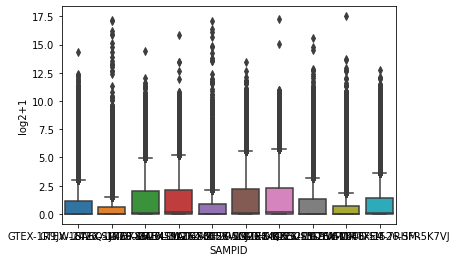

In [71]:
sns.boxplot(data = adatadf_melt, x = 'SAMPID', y = 'log2+1')

In [94]:
def plot_dist(adata):
    adatadf = adata.to_df()
    adatadf_sample = adatadf.T.sample(10, axis = 1)
    adatadf_melt = adatadf_sample.melt()
    adatadf_melt['log2+1'] = np.log2(adatadf_melt.loc[:,'value']+1)
    # Create a box plot of the total bill amount by day
    ax = sns.boxplot(x="SAMPID", y="log2+1", data=adatadf_melt)

    # Rotate x-axis tick labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Add a title to the plot
    ax.set_title("Distribution of Samples")
def plot_dist2(adatadf):
    adatadf_sample = adatadf.sample(10, axis = 1)
    adatadf_melt = adatadf_sample.melt()
    adatadf_melt['log2+1'] = np.log2(adatadf_melt.loc[:,'value']+1)


    # Create a box plot of the total bill amount by day
    ax = sns.boxplot(x="variable", y="log2+1", data=adatadf_melt)

    # Rotate x-axis tick labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Add a title to the plot
    ax.set_title("Distribution of Samples Post Quant Norm")


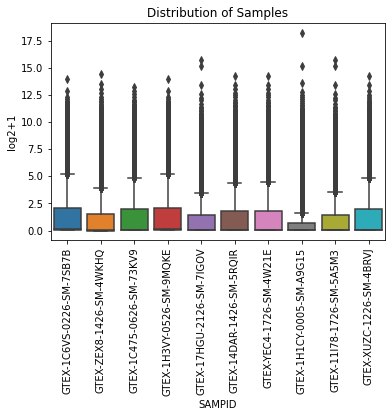

In [72]:
plot_dist(adata)

In [53]:
OPs = adata.obs.SMTS.unique()

In [109]:



def quant_norm_adata(adata):
    quant_normed = []
    
    # Get the organism parts to group by
    OPs = adata.obs.SMTS.unique()
    
    for OP in OPs:
        adataOP = adata[adata.obs.SMTS == OP]
        adataOP.X = quant_norm(adataOP.to_df())
        quant_normed.append(adataOP)
    quantadata = anndata.concat(quant_normed)
    return quantadata


def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

In [120]:
q1 = quantile_normalize(adata.to_df().T)

In [122]:
q1.corr().head()

SAMPID,GTEX-PX3G-0226-SM-DKPOF,GTEX-1PPGY-0326-SM-DTXFD,GTEX-17HHE-1926-SM-7EPGW,GTEX-XOT4-0226-SM-4B66Z,GTEX-15CHQ-0226-SM-6EU2S,GTEX-1K2DA-2126-SM-CGQGL,GTEX-PWCY-1926-SM-3NB25,GTEX-ZG7Y-1626-SM-5S2NO,GTEX-145ME-0726-SM-5O9A3,GTEX-1F6I4-0226-SM-9MQMA,...,GTEX-1HFI7-1126-SM-A96S5,GTEX-PWN1-2526-SM-48TDS,GTEX-1QPFJ-1626-SM-DTX7X,GTEX-1117F-2526-SM-5GZY6,GTEX-1GN1W-1526-SM-7P8TG,GTEX-1QP28-1426-SM-EVR4E,GTEX-TMMY-1926-SM-4DXUU,GTEX-15ER7-2526-SM-7KUFW,GTEX-1A8FM-2426-SM-7IGPE,GTEX-1LH75-1726-SM-DHXKZ
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-PX3G-0226-SM-DKPOF,1.000000,0.377112,0.718471,0.255364,0.490237,0.931393,0.694675,0.417203,0.181435,0.872835,...,0.259064,0.078475,0.195981,0.118583,0.095742,0.089776,0.123607,0.072498,0.087295,0.123557
GTEX-1PPGY-0326-SM-DTXFD,0.377112,1.000000,0.399511,0.280450,0.965710,0.311914,0.234679,0.329859,0.168425,0.521257,...,0.443858,0.104457,0.417981,0.146616,0.130768,0.117420,0.191438,0.097258,0.108622,0.157611
GTEX-17HHE-1926-SM-7EPGW,0.718471,0.399511,1.000000,0.190570,0.515007,0.710124,0.935209,0.507239,0.205767,0.494041,...,0.213167,0.083501,0.155988,0.105681,0.085490,0.078781,0.127946,0.062328,0.081725,0.107827
GTEX-XOT4-0226-SM-4B66Z,0.255364,0.280450,0.190570,1.000000,0.257783,0.201084,0.162828,0.432214,0.181410,0.281511,...,0.383926,0.176920,0.314983,0.229833,0.217337,0.204371,0.238195,0.178296,0.199249,0.589981
GTEX-15CHQ-0226-SM-6EU2S,0.490237,0.965710,0.515007,0.257783,1.000000,0.452753,0.348097,0.360314,0.178045,0.596830,...,0.335742,0.096628,0.310590,0.142863,0.114328,0.103229,0.172051,0.086592,0.098947,0.155228


In [117]:
adata.to_df().T.head()

SAMPID,GTEX-PX3G-0226-SM-DKPOF,GTEX-1PPGY-0326-SM-DTXFD,GTEX-17HHE-1926-SM-7EPGW,GTEX-XOT4-0226-SM-4B66Z,GTEX-15CHQ-0226-SM-6EU2S,GTEX-1K2DA-2126-SM-CGQGL,GTEX-PWCY-1926-SM-3NB25,GTEX-ZG7Y-1626-SM-5S2NO,GTEX-145ME-0726-SM-5O9A3,GTEX-1F6I4-0226-SM-9MQMA,...,GTEX-1HFI7-1126-SM-A96S5,GTEX-PWN1-2526-SM-48TDS,GTEX-1QPFJ-1626-SM-DTX7X,GTEX-1117F-2526-SM-5GZY6,GTEX-1GN1W-1526-SM-7P8TG,GTEX-1QP28-1426-SM-EVR4E,GTEX-TMMY-1926-SM-4DXUU,GTEX-15ER7-2526-SM-7KUFW,GTEX-1A8FM-2426-SM-7IGPE,GTEX-1LH75-1726-SM-DHXKZ
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.000,0.000,0.00000,0.000,0.000,0.000,0.02020,0.000,0.000,0.000,...,0.000,0.000,0.0776,0.000000,0.0000,0.00000,0.00,0.000,0.00000,0.00
WASH7P,4.125,4.859,4.51800,3.446,4.113,2.665,3.20800,4.597,6.115,2.169,...,9.701,4.356,8.2840,16.950001,1.6890,2.33800,7.13,4.044,3.89600,10.17
MIR6859-1,0.000,0.000,0.00000,0.000,0.000,0.000,0.00000,0.000,0.000,0.000,...,0.000,0.000,0.0000,0.000000,0.0000,0.00000,0.00,0.000,0.00000,0.00
MIR1302-2HG,0.000,0.000,0.04005,0.000,0.000,0.000,0.04033,0.000,0.000,0.000,...,0.000,0.000,0.0000,0.000000,0.0996,0.02939,0.00,0.000,0.05584,0.00
FAM138A,0.000,0.000,0.00000,0.000,0.000,0.000,0.00000,0.000,0.000,0.000,...,0.000,0.000,0.0000,0.039040,0.0000,0.00000,0.00,0.000,0.00000,0.00


In [118]:
test1 = pd.DataFrame(quantile_transform(adata.to_df().T))

In [123]:
test.corr().head()

,0,1,2,3,4,5,6,7,8,9,...,550,551,552,553,554,555,556,557,558,559
0,1.000000,0.854571,0.867992,0.866536,0.864538,0.859781,0.847523,0.842924,0.841792,0.867404,...,0.836540,0.823052,0.844001,0.815293,0.818023,0.831223,0.832408,0.822983,0.827418,0.838776
1,0.854571,1.000000,0.860282,0.860288,0.865563,0.848730,0.844753,0.844137,0.844263,0.860761,...,0.843454,0.828008,0.850101,0.810408,0.820728,0.825073,0.838825,0.826461,0.833021,0.832930
2,0.867992,0.860282,1.000000,0.868083,0.867562,0.861887,0.859563,0.849105,0.848713,0.866617,...,0.840050,0.833898,0.850171,0.819469,0.827120,0.833692,0.839672,0.826394,0.830369,0.835188
3,0.866536,0.860288,0.868083,1.000000,0.861973,0.853716,0.847985,0.843139,0.843429,0.865345,...,0.842707,0.841176,0.851959,0.830646,0.833196,0.843829,0.849346,0.840042,0.842941,0.846633
4,0.864538,0.865563,0.867562,0.861973,1.000000,0.855985,0.849150,0.847903,0.850330,0.870936,...,0.848484,0.833460,0.852683,0.821628,0.823665,0.836045,0.843745,0.828907,0.831903,0.842476


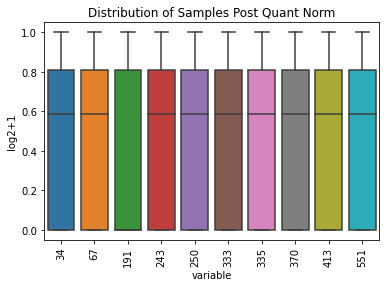

In [96]:
plot_dist2(pd.DataFrame(test))

In [75]:
# create a palette with a unique color for each SMTS value
palette = sns.hls_palette(len(set(adata.obs['SMTS'])), )

# create a dictionary mapping each SMTS value to a color from the palette
mapping = dict(zip(adata.obs.loc[:,'SMTS'].unique(), palette))


adata.obs = adata.obs.set_index('SAMPID')

annotser = adata.obs.loc[:,'SMTS']

# Map colors
colors = [mapping.get(annotser[i]) for i in range(len(annotser))]

# add to annot df
annotdf = pd.DataFrame({'samples':annotser, 'colors':colors})
annotdf = annotdf.drop('samples', axis = 1)


/home/aadrian/anaconda3/envs/PseudoPipelineEnv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


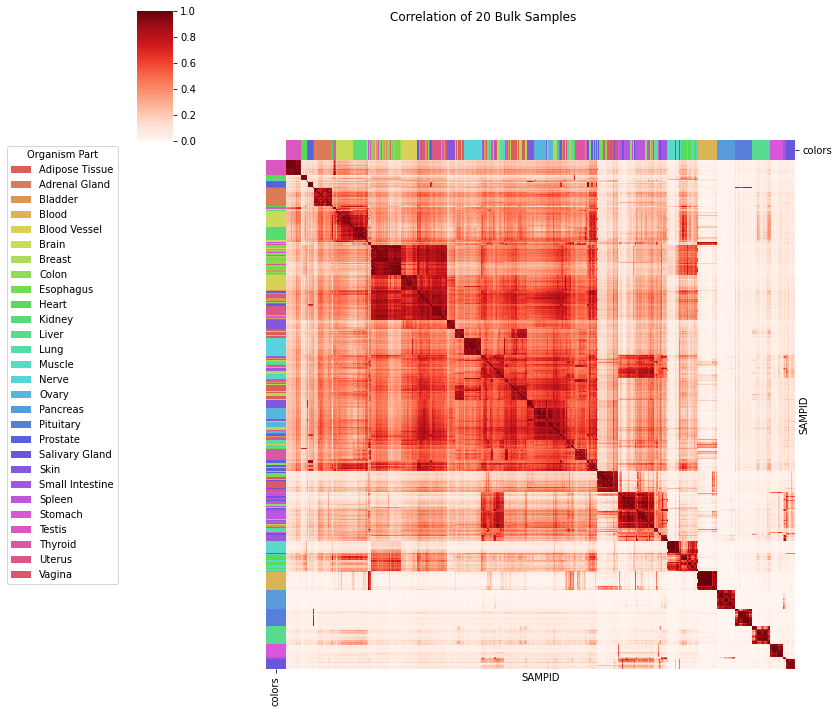

In [85]:
from matplotlib.patches import Patch

adata = anndata.read_h5ad('/pipeline42/datasets/Gtex/GTEx_K20')

adatacor = adata.to_df().transpose().corr()


g = sns.clustermap(adatacor, annot=False, cmap="Reds"
                    ,row_cluster=True, 
                    col_cluster=True,
                    row_colors=annotdf,
                    xticklabels=False,
                    yticklabels=False,
                    col_colors=annotdf
                  )

g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.suptitle('Correlation of 20 Bulk Samples')

handles = [Patch(facecolor=mapping[key]) for key in mapping]
plt.legend(handles, mapping, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

/home/aadrian/anaconda3/envs/PseudoPipelineEnv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


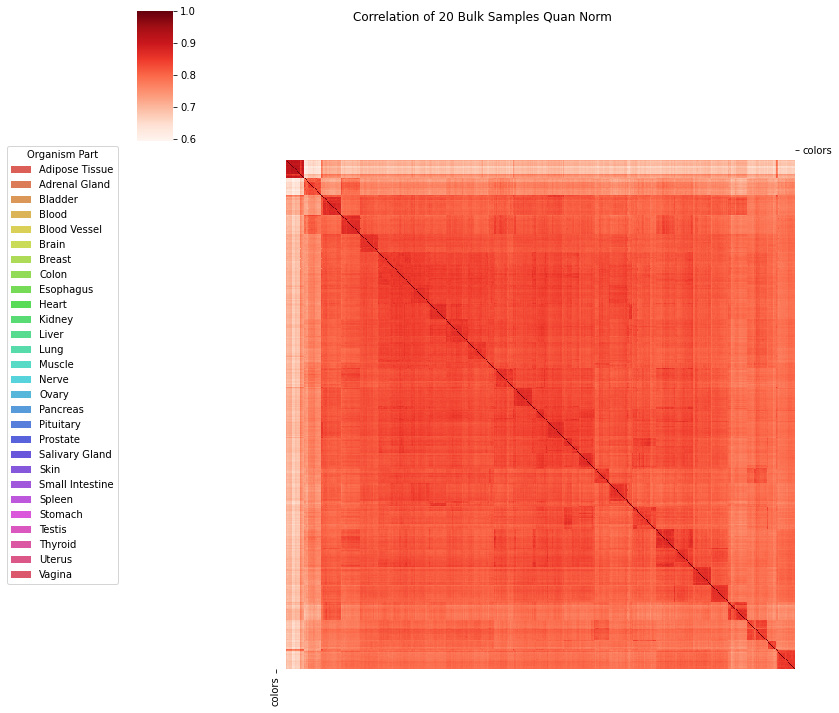

In [125]:
from matplotlib.patches import Patch

adatacor = test.corr()

g = sns.clustermap(adatacor, annot=False, cmap="Reds",
                   row_cluster=True,
                   col_cluster=True,
                   row_colors=annotdf,
                   xticklabels=False,
                   yticklabels=False,
                   col_colors=annotdf)

g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.suptitle('Correlation of 20 Bulk Samples Quan Norm')

handles = [Patch(facecolor=mapping[key]) for key in mapping]
plt.legend(handles, mapping, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')
